In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import scipy.optimize as opt
import scipy.integrate as integrate
from openpyxl import Workbook, load_workbook

INTRODUCTION DES PARAMETRES DU PROBLEME

On implante la fonction alpha (angle d inclinaison de la piste) et la fonction theta (angle que fait la tangente à la noire
avec la tangente au niveau du départ).

In [2]:
#On introduit les paramètres de masse du cycliste, la hauteur de son centre de gravuté et l'intensité du champ de pesanteur
M = 80
LG = 0.8
g = 9.81

def alpha(s):
    s = s % 250
    return np.pi *2 / 180 *(13.3 + 30.6 *(1 - abs(np.cos(2*np.pi*(s+10)/250)**3)))

def theta(s):
    n = s // 250
    s = s - 250 *n
    x = (2*(np.sin(2*np.pi*(s+10)/250))**5)/(1 + (np.sin(2*np.pi*(s+10)/250))**4)
    if s <= 52.5:
        return np.arcsin(x) + 2 * np.pi * n
    if s <= 177.5:
        return np.pi - np.arcsin(x) + 2 * np.pi * n
    return np.arcsin(x) + 2 *np.pi + 2 * np.pi * n


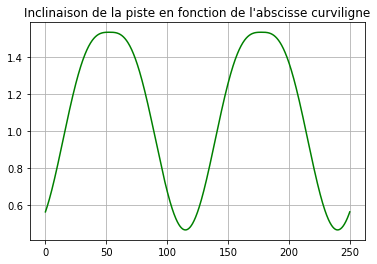

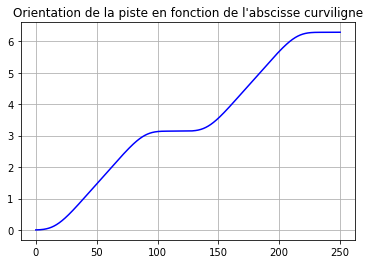

In [3]:
#Plot de la paramétrisation
S = np.linspace(0,250,1000)

a = np.vectorize(alpha)
t = np.vectorize(theta)

A = a(S)
T = t(S)

plt.figure()
plt.plot(S,A,'-g')
plt.title("Inclinaison de la piste en fonction de l'abscisse curviligne")
plt.grid(True)

plt.figure()
plt.plot(S,T,'-b')
plt.grid(True)
plt.title("Orientation de la piste en fonction de l'abscisse curviligne")
plt.show()


Le rayon de courbure dans la ligne droite est :  1060.9 m
Le rayon de courbure dans le virage est :  23.0 m


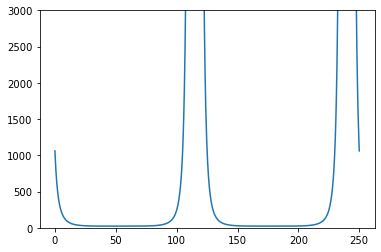

In [4]:
def Rc(s): 
    h = 10**(-1)
    dTheta = (theta(s + h) - theta(s))/h
    if dTheta < 10**(-7):
        return 10000000
    return 1/dTheta
print("Le rayon de courbure dans la ligne droite est : ", round(Rc(0), 1), "m")
print("Le rayon de courbure dans le virage est : ", round(Rc(50), 1), "m")

S = np.linspace(0,250,1000)
Rc_vect = np.vectorize(Rc)

plt.figure()
plt.plot(S, Rc_vect(S))
axes = plt.gca()
axes.set_ylim(0, 3000)
plt.show()


On définit maintenant la fonction beta qui fournit l'inclinaison du cycliste par rapport à la verticale. Celle-ci est fonction
de l'inclinaison de la piste et de la vitesse du cycliste (plus celui-ci va vite et plus il devra s'incliner dans le virage 
pour conserver son équilibre)

V =  18  m/s


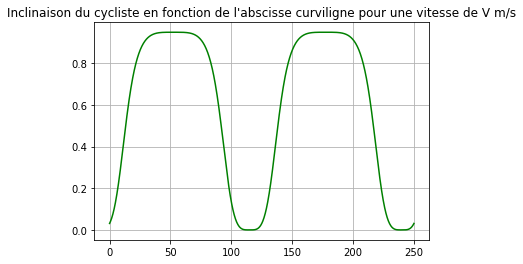

In [5]:
def beta(s, V): 
    def f(x): 
        return np.tan(x) - ((1-(LG * np.sin(x)/Rc(s)))*V**2)/(g * Rc(s))
    x = opt.root(f, 0.4).x[0]
    return x

V = 18
S = np.linspace(0,250,1000)

B = np.array([beta(s,V) for s in S])

plt.figure()
plt.plot(S,B,'-g')
plt.title("Inclinaison du cycliste en fonction de l'abscisse curviligne pour une vitesse de V m/s")
plt.grid(True)
print ("V = ", V, " m/s")

Le paramètre lambda suivant caractérise la variation entre la vitesse du centre de gravité du cycliste et celle du bout de ses roues dans le virage : vitesse du centre de gravité = vitesse des roues * lambda

In [6]:
def lam(s, V):
    return 1 - LG * np.sin(beta(s,V))/Rc(s)

### PREMIERE APPROCHE : On fixe une vitesse à atteindre et on étudie la puissance que doit fournir le cycliste

On introduit comme paramètres V la vitesse souhaitée ; SCd le produit surface de référence * coefficient aérodynamique (estimé grâce à celui fourni par Sébastien Laigret) ; mu ; rho ; eta le rendement de la chaîne et du pédalier et drag_red le pourcentage de trainée aérodynamique subi par le deuxième cycliste car il est protégé par le premier.


In [7]:
V = 16.7

SCd = 0.205
#On avait mis 0.527 avec tes mesures mais le C est important, SCd n'est pas juste une surface j'ai donc repris les mesures de Seb Laigret ; d'après lui ça varie entre 0.23 et 0.31 ; d'après son optimisation sur la réalité il trouve 0.205
mu = 0.0045
#Idem pour mu, il y a une diff entre ce que trouve Seb en théorie et la valeur pratique qui colle le plus à son bail. Ici encore je prends ce qu'il a pris pour créer son modèle
rho = 1.2
eta = 0.98
drag_red = 0.55

En fonction de ces paramètres, on a la puissance musculaire à fournir par le premier cycliste pour se maintenir à une certaine vitesse. On a aussi les variations d'énergie mécanique et la puissance aérodynamique.

In [8]:
def Pm_1(s):
    h = 10**(-1)
    dEm = M * (lam(s + h, V) - lam(s, V))* lam(s,V)/h*V**2 + M*g*LG*(np.cos(beta(s+h,V))-np.cos(beta(s,V)))/h
    Paero = 0.5 * rho * SCd * (lam(s,V))**3 * (V **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V))/np.cos(beta(s,V))
    return ((dEm + Paero + Pfric)*V / eta)

def dEm(s):
    h = 10**(-1)
    dEm = M * (lam(s + h, V) - lam(s, V))* lam(s,V)/h*V**2 + M*g*LG*(np.cos(beta(s+h,V))-np.cos(beta(s,V)))/h
    return (dEm*V)

def Paero (s) :
    h = 10**(-1)
    Paero = 0.5 * rho * SCd * (lam(s,V))**3 * (V **3)
    return (Paero)

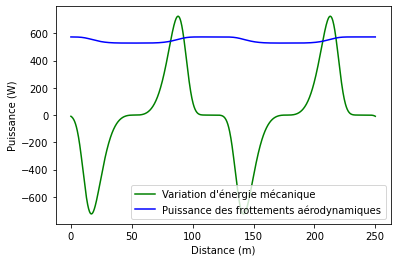

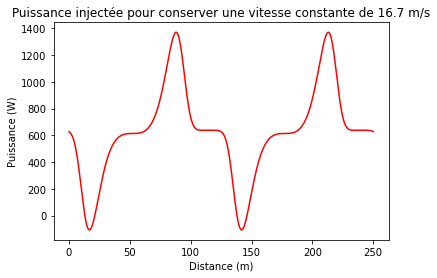

V =  16.7  m/s


In [9]:
Pm1_vect = np.vectorize(Pm_1)
dEm_vect = np.vectorize(dEm)
Paero_vect = np.vectorize(Paero)

S = np.linspace(0,250, 1000)
P1 = Pm1_vect(S)
P2 = dEm_vect(S)
P3 = Paero_vect(S)
plt.figure()
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.plot(S, P2, '-g', label = "Variation d'énergie mécanique")
plt.plot(S,P3, '-b', label = "Puissance des frottements aérodynamiques")
plt.legend()

plt.figure()
plt.plot(S,P1,'-r')
plt.title("Puissance injectée pour conserver une vitesse constante de " + str(V) + " m/s")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.savefig("power_one_cylist.png")
plt.show()

print ("V = ", V, " m/s")

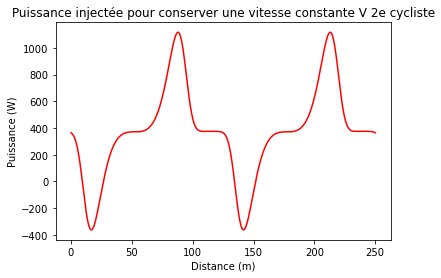

V =  16.7  m/s


In [10]:
def Pm_2(s):
    h = 10**(-1)
    dEm = M * (lam(s + h, V) - lam(s, V))*lam(s,V)/h*(V**2) + M*g*LG*(np.cos(beta(s+h,V))-np.cos(beta(s,V)))/h
    Paero = drag_red *0.5 * rho * SCd * (lam(s,V))**3 * (V **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V))/np.cos(beta(s,V))
    return ((dEm + Paero + Pfric)*V / eta)

Pm2_vect = np.vectorize(Pm_2)

S = np.linspace(0,250, 1000)
P2 = Pm2_vect(S)
plt.figure()
plt.plot(S,P2,'-r')
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.title("Puissance injectée pour conserver une vitesse constante V 2e cycliste")
plt.show()

print ("V = ", V, " m/s")

On s'intéresse maintenant à la différence de puissance musculaire entre les deux cyclistes

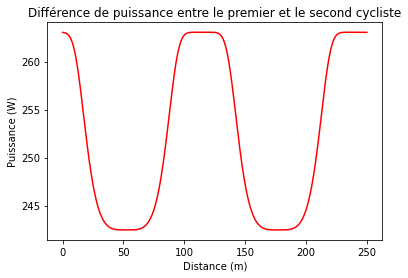

In [11]:
S = np.linspace(0,250, 1000)

def diff (s):
    return (Pm_1(s) - Pm_2(s))

diff_vect = np.vectorize(diff)

P = diff_vect(S)
plt.plot(S,P,'-r')
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.title("Différence de puissance entre le premier et le second cycliste")
plt.show()

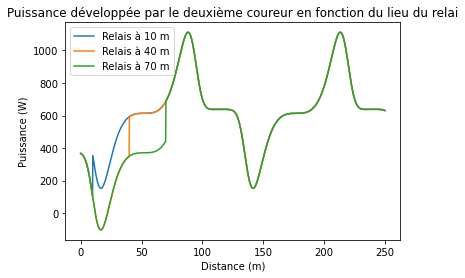

In [12]:
def drag_reduction(s):
    if s < s_0:
        return 0.55
    return 1

def Pm_2_relay(s):
    h = 10**(-1)
    dEm = 0.5 * M * (lam(s + h, V) - lam(s, V))/h*(V**2) + M*g*LG*(np.cos(beta(s+h,V))-np.cos(beta(s,V)))/h
    Paero = drag_reduction(s) *0.5 * rho * SCd * (lam(s,V))**3 * (V **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V))/np.cos(beta(s,V))
    return ((dEm + Paero + Pfric)*V / eta)



S = np.linspace(0,250, 1000)
s_0 = 10
Pm_2_relay_vect = np.array([Pm_2_relay(s) for s in S])
plt.figure()
plt.title("Puissance développée par le deuxième coureur en fonction du lieu du relai")
plt.plot(S,Pm_2_relay_vect, label = "Relais à 10 m")

s_0 = 40
Pm_2_relay_vect = np.array([Pm_2_relay(s) for s in S])
plt.plot(S,Pm_2_relay_vect, label = "Relais à 40 m")

s_0 = 70
Pm_2_relay_vect = np.array([Pm_2_relay(s) for s in S])
plt.plot(S,Pm_2_relay_vect, label = "Relais à 70 m")


plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")

plt.legend()

plt.show()

### DEUXIEME APPROCHE : La puissance injectée est fournie, on cherche à déterminer la vitesse 

In [13]:
def z(s,V): 
    return LG*np.cos(beta(s,V))

def next_point(s, V, P, h):
    def f(x): 
        dEc = 0.5 * M *(lam(s + h, x)**2 * x**2 - lam(s, V)**2 * V**2)
        dEp = M * g * (z(s + h, x) - z(s, V))
        Pow = P/V - 0.5 * rho * SCd * lam(s,V)**3 * V**2 - mu*M*g*np.cos(alpha(s)-beta(s,V))/np.cos(beta(s,V))
        return (dEp + dEc)/h - Pow
    x = opt.root(f, V).x[0]
    return x

def next_point_2(s, V, P, h):
    def f(x): 
        dEc = 0.5 * M *(lam(s + h, x)**2 * x**2 - lam(s, V)**2 * V**2)
        dEp = M * g * (z(s + h, x) - z(s, V))
        Pow = P/V - drag_red * 0.5 * rho * SCd * lam(s,V)**3 * V**2 - mu*M*g*np.cos(alpha(s)-beta(s,V))/np.cos(beta(s,V))
        return (dEp + dEc)/h - Pow
    x = opt.root(f, V).x[0]
    return x

In [14]:
def P_const(s):
        return 600

def Vitesse(V_0, S, P):
    n = len(S)
    res = [V_0]
    V = V_0
    h = S[1] - S[0]
    for i in range(1,n):
        s = S[i]
        V = next_point(s, V, P(s), h)
        res = res + [V]
    return np.array(res)

def Vitesse_2(V_0, S, P):
    n = len(S)
    res = [V_0]
    V = V_0
    h = S[1] - S[0]
    for i in range(1,n):
        s = S[i]
        V = next_point_2(s, V, P(s), h)
        res = res + [V]
    return np.array(res)

def time (V):
    t = 0
    for i in V:
        t+= 1 / i
    return t

def timeLastHalfLap(V):
    res = 0
    for i in range (875, 1000):
        res += 1 / V[i]
    return res

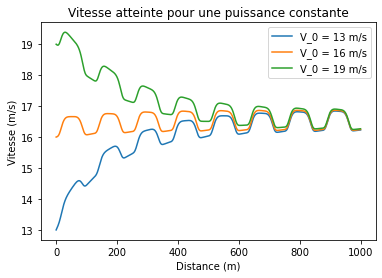

In [15]:
S = np.linspace(0,1000, 1000)
V_1 = Vitesse(13, S, lambda x : P_const(x))
V_2 = Vitesse(16, S, lambda x : P_const(x))
V_3 = Vitesse(19, S, lambda x : P_const(x))
plt.figure()
plt.title("Vitesse atteinte pour une puissance constante")
plt.plot(S,V_1, label = "V_0 = 13 m/s")
plt.plot(S,V_2, label = "V_0 = 16 m/s")
plt.plot(S,V_3, label = "V_0 = 19 m/s")


plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")

plt.legend()
plt.savefig("speed_one_cyclist.png")
plt.show()

On remarque ici, l'influence de la vitesse initiale. Comme nous souhaitons nous placer en régime stationnaire, il nous faut trouver la vitesse initiale qui, pour une puissance donnée, annule la dépendance en exponentielle décroissante. 
(Note : la méthode ne fonctionne pas pour V_0 trop proche de 0 m/s)

In [16]:
def V_init(P):
    def f(x):
        return P/x - 0.5 * rho * SCd * x**2  - mu * M *g
    x = opt.root(f, 10).x[0]
    return x
print(V_init(600))

16.395480780851766


Première approche (naïve) : pour une valeur d énergie donnée, on cherche à minimiser le temps de passage aux 500m par exemple :
il s agit alors de trouver P une fonction de s dont l'intégrale vaut E et pour laquelle le temps de parcours est optimal.
D après la thèse de Sébastien Laigret (boost de puissance), on peut chercher à augmenter la puissance aux sorties de virage (75 et 200 m) et à la diminuer en entrée de virage (25 et 150 m)

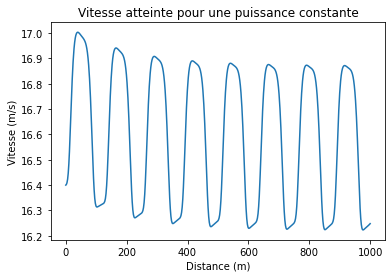

V_0 =  16.4  m/s


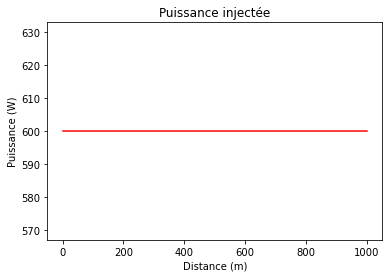

temps total = 60.27240947824041
temps dernier demi-tour = 7.547639428161228


In [17]:
V_init = 16.4
    
S = np.linspace(0,1000, 1000)
V_1 = Vitesse(V_init, S, lambda x : P_const(x))
plt.figure()
plt.title("Vitesse atteinte pour une puissance constante")
plt.plot(S, V_1)
plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")
plt.show()

print ("V_0 = ", V_init, " m/s")

Pvector = np.vectorize(P_const)
plt.figure()
plt.title("Puissance injectée")
plt.plot(S, Pvector(S), '-r')
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.show()


print ("temps total =", time(V_1))
print ("temps dernier demi-tour =", timeLastHalfLap(V_1))

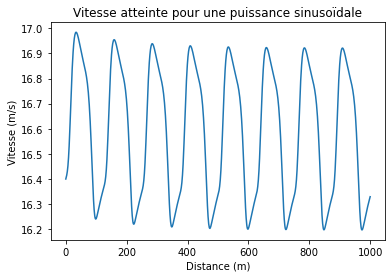

V_0 =  16.4  m/s


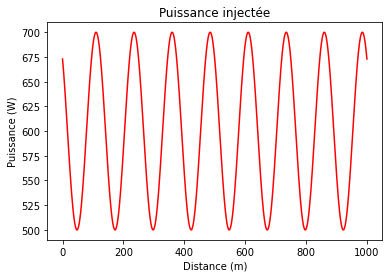

temps total = 60.29391529913501
temps dernier demi-tour = 7.543082854014498


In [18]:
Pmoyenne = 600
DeltaP = 200

def P_sin(s):
    result = Pmoyenne + DeltaP/2*np.cos((s-110)/125*2*np.pi)
    return result

    
S = np.linspace(0,1000, 1000)
V_1 = Vitesse(V_init, S, lambda x : P_sin(x))
plt.figure()
plt.title("Vitesse atteinte pour une puissance sinusoïdale")
plt.plot (S, V_1)
plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")
plt.show()

print ("V_0 = ", V_init, " m/s")


Psinvector = np.vectorize(P_sin)
plt.figure()
plt.title("Puissance injectée")
plt.plot(S, Psinvector(S), '-r')
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.show()

print ("temps total =", time(V_1))
print ("temps dernier demi-tour =", timeLastHalfLap(V_1))

In [19]:
S = np.linspace(0,1000, 1000)

def Vitessephi(V_0, S, phi):
    def Pphi(s):
        result = Pmoyenne + DeltaP/2*np.cos((s-phi)/125*2*np.pi)
        return result
    res = [V_0]
    V = V_0
    h = S[1] - S[0]
    for i in range(1,1000):
        s = S[i]
        V = next_point(s, V, Pphi(s), h)
        res = res + [V]
    return np.array(res)

def optisinus(nb_div):
    def timeangle(phi):
        V = Vitessephi(V_init, S, phi)
        t = timeLastHalfLap(V)
        return t
    times = np.array([0.0 for i in range (nb_div)])
    for i in range(nb_div):
        phi0 = i*125/nb_div
        times[i] = timeangle(phi0)
    return times


In [20]:
nb_div = 5

T = optisinus (nb_div)

    

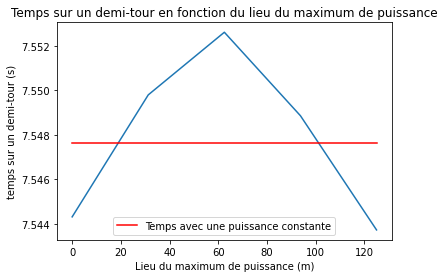

In [21]:
D = np.linspace (0,125, nb_div)
R = np.array([7.547639428161249 for i in range (nb_div)])

plt.figure()
plt.title("Temps sur un demi-tour en fonction du lieu du maximum de puissance")
plt.plot(D, T)
plt.plot(D, R, '-r', label = "Temps avec une puissance constante")
plt.xlabel("Lieu du maximum de puissance (m)")
plt.legend()
plt.ylabel("temps sur un demi-tour (s)")
plt.show()        


### Troisième approche: Puissance du premier fixée, vitesse du second fixée par celle du premier. 

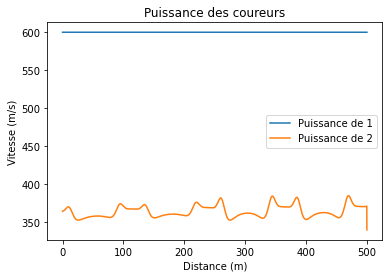

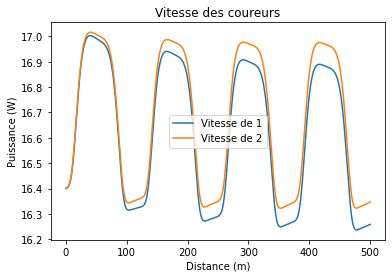

In [22]:
V_init = 16.4


dmax = 500
h = 10**(-1)

S = np.linspace(0,dmax,int(dmax/h))
V_1 = Vitesse(V_init, S, lambda x: P_const(x))
def V_head(s):
    return V_1[min(round(s/h), int(dmax/h) - 1)]

def P_2(s):
    dEm = M * 0.5 * ((lam(s + h, V_head(s+h))*V_head(s+h))**2 - (lam(s, V_head(s))*V_head(s))**2)/h + M*g*LG*(np.cos(beta(s+h,V_head(s+h)))-np.cos(beta(s,V_head(s))))/h
    Paero = drag_red * 0.5 * rho * SCd * (lam(s,V_head(s)))**3 * (V_head(s) **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V_head(s)))/np.cos(beta(s,V_head(s)))
    return ((dEm + Paero + Pfric)*V_head(s) / eta)

V_2 = Vitesse_2(V_init, S, lambda x: P_2(x))
P_1_vect = np.vectorize(P_const)
P_2_vect = np.vectorize(P_2)

plt.figure()
plt.title("Puissance des coureurs")
plt.plot(S, P_1_vect(S), label = "Puissance de 1")
plt.plot(S, P_2_vect(S), label = "Puissance de 2")

plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")

plt.legend()
plt.savefig("speed_2_cyclists.png")
plt.figure()
plt.title("Vitesse des coureurs")
plt.plot(S,V_1, label = "Vitesse de 1")
plt.plot(S,V_2, label = "Vitesse de 2")

plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")

plt.legend()
plt.savefig("power_2_cyclists.png")
plt.show()



### Test avec les données de C. Ermenault

In [23]:
wb = load_workbook(filename = 'donnees_ermenault.xlsx', data_only = True)
ws = wb.active
T_erm = []
V_erm = []
P_erm = []

i = 4
while(ws.cell(row = i, column = 1).value != None):
    T_erm += [ws.cell(row = i, column = 1).value]
    V_erm += [ws.cell(row = i, column = 6).value]
    P_erm += [ws.cell(row = i, column = 2).value]
    i += 1

In [24]:
X_erm = np.array([0.0]*len(T_erm))
for i in range(1, len(T_erm)):
    x = integrate.simps(np.array(V_erm)[0:i], np.array(T_erm)[0:i])
    X_erm[i-1] = x + 132

In [25]:
def V_erm_inter(x):
    i = 0
    imax = len(T_erm)
    while (i+1 < imax) and (x >= X_erm[i+1]):
        i += 1
    if(i == imax):
        return 0
    return V_erm[i] + (V_erm[i+1] - V_erm[i])/(X_erm[i+1] - X_erm[i]) * (x - X_erm[i])


def P_erm_inter(x):
    i = 0
    imax = len(T_erm)
    while (i+1 < imax) and (x >= X_erm[i+1]):
        i += 1
    if(i == imax):
        return 0
    return P_erm[i] + (P_erm[i+1] - P_erm[i])/(X_erm[i+1] - X_erm[i]) * (x - X_erm[i])

#### Interpolation des courbes initiales: Splines

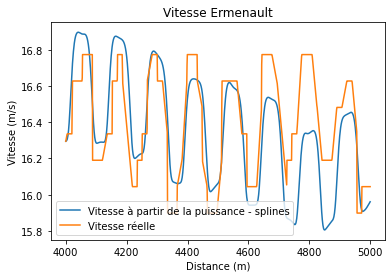

In [26]:
rho = 1.12
SCd = 0.18

s_min = 4000
s_max = 5000
n = 100 #interpolation des splines
N = 1000
d_conv = 20
n_conv = 100

S = np.linspace(s_min, s_max, n);

V_erm_vect = np.vectorize(V_erm_inter)
P_erm_vect = np.vectorize(P_erm_inter)

P_splines = make_interp_spline(S, P_erm_vect(S), bc_type = "natural")
V_splines = make_interp_spline(S, V_erm_vect(S), bc_type = "natural")

S = np.linspace(s_min, s_max, N);
V_1 = Vitesse(V_erm_inter(S[0]), S, lambda x: P_splines(x))



plt.figure()
plt.title("Vitesse Ermenault")
plt.plot(S,V_1, label = "Vitesse à partir de la puissance - splines")
plt.plot(S,V_erm_vect(S), label = "Vitesse réelle")

plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")

plt.legend()
plt.savefig("v_model.png")
plt.show()

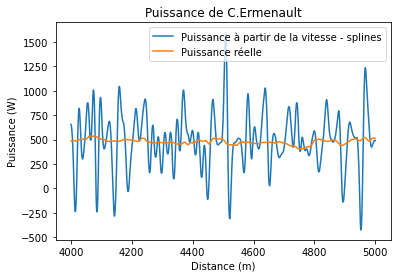

In [27]:
def P_erm_model(s):
    h = 0.1
    dEm = M * 0.5 * ((lam(s + h, V_splines(s+h))*V_splines(s+h))**2 - (lam(s, V_splines(s))*V_splines(s))**2)/h + M*g*LG*(np.cos(beta(s+h,V_splines(s+h)))-np.cos(beta(s,V_splines(s))))/h
    Paero = 0.5 * rho * SCd * (lam(s,V_splines(s)))**3 * (V_splines(s) **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V_splines(s)))/np.cos(beta(s,V_splines(s)))
    return ((dEm + Paero + Pfric)*V_splines(s) / eta)

P_erm_model_vect = np.vectorize(P_erm_model)

plt.figure()
plt.title("Puissance de C.Ermenault")

plt.plot(S, P_erm_model_vect(S), label = "Puissance à partir de la vitesse - splines")
plt.plot(S, P_splines(S), label = "Puissance réelle")

plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")

plt.legend()
plt.savefig("p_model.png")
plt.show()

#### Interpolation des courbes: Convolution

In [28]:
def convolution(f, eps, x):
    X = np.linspace(x-eps, x+eps, n_conv)
    return integrate.simps(f(X), X)/(2*eps)

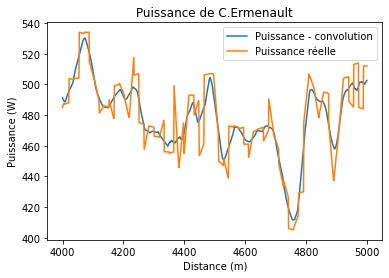

In [29]:
def P_erm_moy(x):
    return convolution(P_erm_vect, d_conv, x)

P_erm_moy_vect = np.vectorize(P_erm_moy)
plt.figure()
plt.title("Puissance de C.Ermenault")
plt.plot(S, P_erm_moy_vect(S), label = "Puissance - convolution")
plt.plot(S, P_erm_vect(S), label = "Puissance réelle")

plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")

plt.legend()
plt.savefig("p_conv.png")
plt.show()

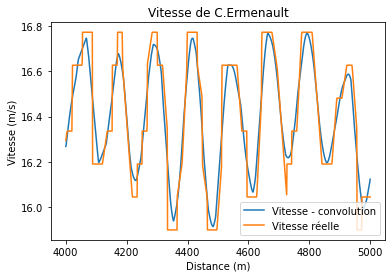

In [30]:
def V_erm_moy(x):
    return convolution(V_erm_vect, d_conv, x)

V_erm_moy_vect = np.vectorize(V_erm_moy)
plt.figure()
plt.title("Vitesse de C.Ermenault")
plt.plot(S, V_erm_moy_vect(S), label = "Vitesse - convolution")
plt.plot(S, V_erm_vect(S), label = "Vitesse réelle")

plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")

plt.legend()
plt.savefig("v_conv.png")
plt.show()

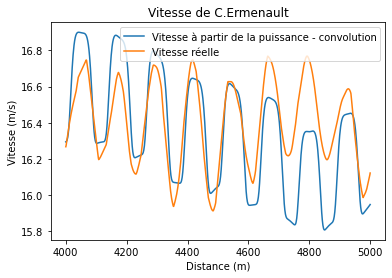

In [31]:
V_1 = Vitesse(V_erm_inter(S[0]), S, lambda x: P_erm_moy(x))

plt.figure()
plt.title("Vitesse de C.Ermenault")
plt.plot(S,V_1, label = "Vitesse à partir de la puissance - convolution")
plt.plot(S,V_erm_moy_vect(S), label = "Vitesse réelle")

plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")

plt.legend()

plt.show()

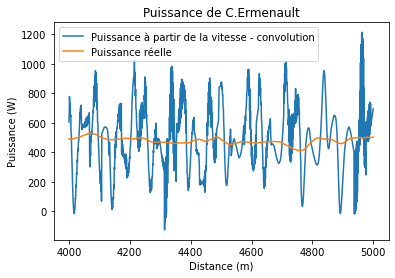

In [32]:
def P_erm_model(s):
    h = 0.1
    dEm = M * 0.5 * ((lam(s + h, V_erm_moy(s+h))*V_erm_moy(s+h))**2 - (lam(s, V_erm_moy(s))*V_erm_moy(s))**2)/h + M*g*LG*(np.cos(beta(s+h,V_erm_moy(s+h)))-np.cos(beta(s,V_erm_moy(s))))/h
    Paero = 0.5 * rho * SCd * (lam(s,V_erm_moy(s)))**3 * (V_erm_moy(s) **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V_erm_moy(s)))/np.cos(beta(s,V_erm_moy(s)))
    return ((dEm + Paero + Pfric)*V_erm_moy(s) / eta)

P_erm_model_vect = np.vectorize(P_erm_model)


plt.figure()
plt.title("Puissance de C.Ermenault")
plt.plot(S, P_erm_model_vect(S), label = "Puissance à partir de la vitesse - convolution")
plt.plot(S, P_erm_moy_vect(S), label = "Puissance réelle")

plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")

plt.legend()

plt.show()

#### Écart de puissance à la valeur moyenne

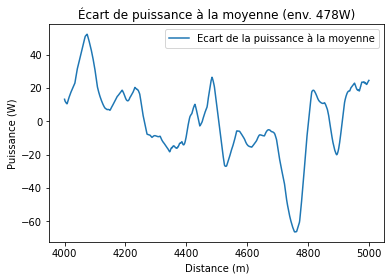

In [33]:
m = integrate.simps(P_erm_moy_vect(S), S)/(s_max - s_min);
plt.figure()
titre = "Écart de puissance à la moyenne (env. " + str(int(m)) + "W)"
plt.title(titre)
plt.plot(S, P_erm_moy_vect(S)-m, label = "Ecart de la puissance à la moyenne")

plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")

plt.legend()

plt.show()

#### Filtrage du résultat final

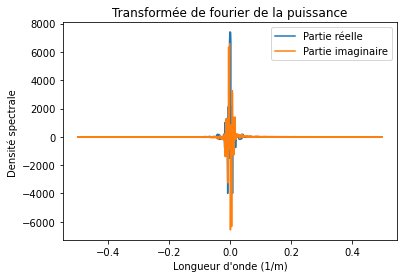

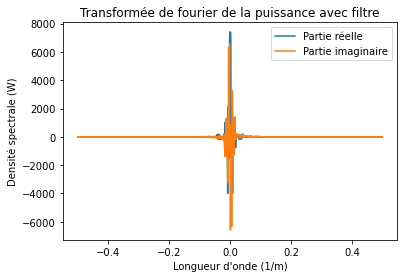

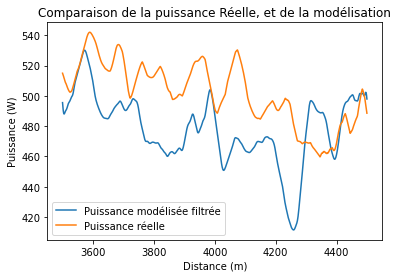

In [34]:
P_f = np.fft.fft(P_erm_moy_vect(S)-m)
dx = S[1] - S[0]
F = np.fft.fftfreq(len(S), dx)
f_coupure = 0.1

plt.figure()
plt.title("Transformée de fourier de la puissance")
plt.plot(F, P_f.real, label = "Partie réelle")
plt.plot(F, P_f.imag, label = "Partie imaginaire")
plt.xlabel("Longueur d'onde (1/m)")
plt.ylabel("Densité spectrale ")
plt.legend()
plt.show()
filtre = np.array([(-abs((f-f_coupure)*(f+f_coupure))/((f-f_coupure)*(f+f_coupure)) + 1)/2 for f in F])

P_f_filtre = P_f*filtre
plt.figure()
plt.title("Transformée de fourier de la puissance avec filtre")
plt.plot(F, (P_f_filtre).real, label = "Partie réelle")
plt.plot(F, (P_f_filtre).imag, label = "Partie imaginaire")
plt.xlabel("Longueur d'onde (1/m)")
plt.ylabel("Densité spectrale (W)")
plt.legend()
plt.show()

dk = F[1] - F[0]
filtered = np.fft.ifft(P_f_filtre)
X = np.fft.fftfreq(len(F), dk)
X = np.fft.fftshift(X) + s_min
plt.figure()
plt.title("Comparaison de la puissance Réelle, et de la modélisation")
plt.plot(X, filtered.real+m, label  = "Puissance modélisée filtrée")
plt.plot(X, P_erm_moy_vect(X), label = "Puissance réelle")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.legend()
plt.savefig("p_filtre.png")
plt.show()

### Données de l'équipe de France de poursuite par équipe

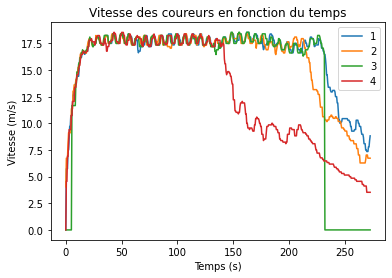

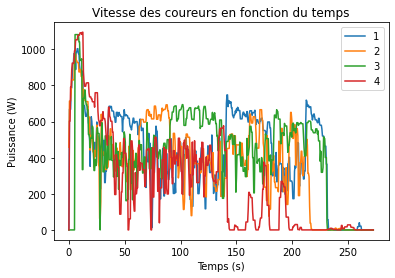

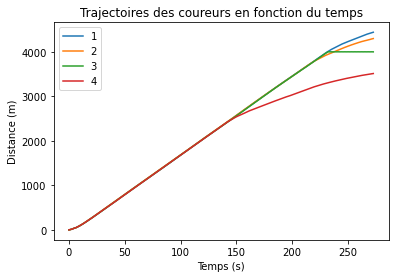

In [176]:
wb = load_workbook(filename = 'donnees_goldencheetah.xlsx', data_only = True)
ws = wb["Exploit GM"]
T = []
V = []
P = []
X = []
test = []
i = 6
while(ws.cell(row = i, column = 1).value != None):
    T += [ws.cell(row = i, column = 1).value]
    V += [[ws.cell(row = i, column = 3 + j).value/3.6 for j in range(4)]]
    P += [[ws.cell(row = i, column = 8 + j).value for j in range(4)]]
    X += [ws.cell(row = i, column = 13).value]
    i += 1
T = np.array(T)
V = np.array(V)
P = np.array(P)
X = np.array(X)


V, P = np.transpose(V), np.transpose(P)
test = [[X[i]] * 4 for i in range(12)]

off = X[11]
for i in range(1, len(T) - 11):
    x = [[off + integrate.simps(np.array(V[j])[12:12 + i], np.array(T)[12:12 + i]) for j in range(4)]]
    test += x
test = np.array(test)
test = np.transpose(test)

A_1 = 3
A_2 = 0
A_3 = 1
A_4 = 2

plt.figure()
plt.plot(T, V[0], label = "1")
plt.plot(T, V[1], label = "2")
plt.plot(T, V[2], label = "3")
plt.plot(T, V[3], label = "4")
plt.xlabel("Temps (s)")
plt.ylabel("Vitesse (m/s)")
plt.title("Vitesse des coureurs en fonction du temps")
plt.legend()

plt.figure()
plt.plot(T, P[0], label = "1")
plt.plot(T, P[1], label = "2")
plt.plot(T, P[2], label = "3")
plt.plot(T, P[3], label = "4")
plt.xlabel("Temps (s)")
plt.ylabel("Puissance (W)")
plt.title("Vitesse des coureurs en fonction du temps")
plt.legend()

plt.figure()
plt.plot(T, test[0], label = "1")
plt.plot(T, test[1], label = "2")
plt.plot(T, test[2], label = "3")
plt.plot(T, test[3], label = "4")
plt.xlabel("Temps (s)")
plt.ylabel("Distance (m)")
plt.title("Trajectoires des coureurs en fonction du temps")
plt.legend()

plt.show()



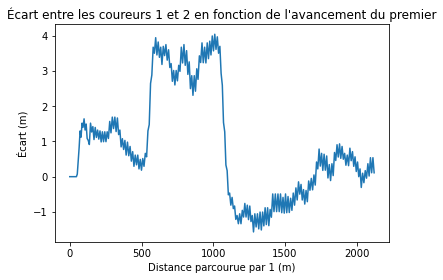

In [178]:
plt.figure()
plt.plot(test[0,0:250], (test[0]-test[3])[0:250])
plt.title("Écart entre les coureurs 1 et 2 en fonction de l'avancement du premier")
plt.xlabel("Distance parcourue par 1 (m)")
plt.ylabel("Écart (m)")

plt.show()

In [180]:
X = test

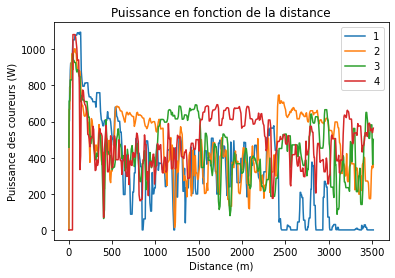

In [181]:
def P_1(x):
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_1, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return P[A_1, i] + (P[A_1, i+1] - P[A_1, i])/(X[A_1, i+1] - X[A_1, i]) * (x - X[A_1, i])

def P_2(x): 
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_2, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return P[A_2, i] + (P[A_2, i+1] - P[A_2, i])/(X[A_2, i+1] - X[A_2, i]) * (x - X[A_2, i])

def P_3(x): 
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_3, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return P[A_3, i] + (P[A_3, i+1] - P[A_3, i])/(X[A_3, i+1] - X[A_3, i]) * (x - X[A_3, i])

def P_4(x): 
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_4, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return P[A_4, i] + (P[A_4, i+1] - P[A_4, i])/(X[A_4, i+1] - X[A_4, i]) * (x - X[A_4, i])

P_1 = np.vectorize(P_1)
P_2 = np.vectorize(P_2)
P_3 = np.vectorize(P_3)
P_4 = np.vectorize(P_4)

plt.figure()
plt.plot(X[3], P_1(X[3]), label = "1")
plt.plot(X[3], P_2(X[3]), label = "2")
plt.plot(X[3], P_3(X[3]), label = "3")
plt.plot(X[3], P_4(X[3]), label = "4")
plt.title("Puissance en fonction de la distance")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance des coureurs (W)")
plt.legend()

plt.show()

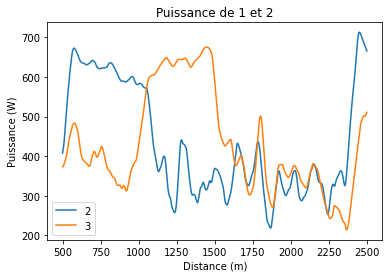

In [182]:
start = 500
end = 2500
rho = 1.12
SCd = 0.18

S = np.linspace(start, end, 1000)

def P_1_conv(s):
    return convolution(P_1, 40, s)

def P_2_conv(s):
    return convolution(P_2, 40, s)

def P_3_conv(s):
    return convolution(P_3, 40, s)

def P_4_conv(s):
    return convolution(P_4, 40, s)

P_1_conv = np.vectorize(P_1_conv)
P_2_conv = np.vectorize(P_2_conv)
P_3_conv = np.vectorize(P_3_conv)
P_4_conv = np.vectorize(P_4_conv)

plt.figure()
plt.plot(S, P_2_conv(S), label = "2")
plt.plot(S, P_3_conv(S), label = "3")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.title("Puissance de 1 et 2")
plt.legend()

plt.show()

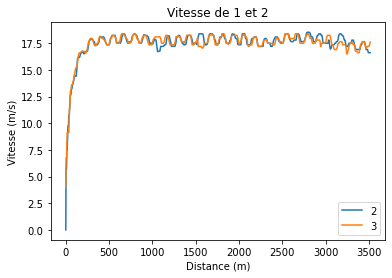

In [183]:
def V_1(x):
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_1, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return V[A_1, i] + (V[A_1, i+1] - V[A_1, i])/(X[A_1, i+1] - X[A_1, i]) * (x - X[A_1, i])

def V_2(x): 
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_2, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return V[A_2, i] + (V[A_2, i+1] - V[A_2, i])/(X[A_2, i+1] - X[A_2, i]) * (x - X[A_2, i])

def V_3(x): 
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_3, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return V[A_3, i] + (V[A_3, i+1] - V[A_3, i])/(X[A_3, i+1] - X[A_3, i]) * (x - X[A_3, i])

def V_4(x): 
    i = 0
    imax = len(X[0])
    while (i+1 < imax) and (x >= X[A_4, i+1]):
        i += 1
    if(i == imax-1):
        return 0
    return V[A_4, i] + (V[A_4, i+1] - V[A_4, i])/(X[A_4, i+1] - X[A_4, i]) * (x - X[A_4, i])

V_1 = np.vectorize(V_1)
V_2 = np.vectorize(V_2)
V_3 = np.vectorize(V_3)
V_4 = np.vectorize(V_4)

plt.figure()
plt.plot(X[3], V_2(X[3]), label = "2")
plt.plot(X[3], V_3(X[3]), label = "3")
plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")
plt.title("Vitesse de 1 et 2")
plt.legend()

plt.show()

In [155]:
def next_point(s, drag_red, V, P, h):
    def f(x): 
        dEc = 0.5 * M *(lam(s + h, x)**2 * x**2 - lam(s, V)**2 * V**2)
        dEp = M * g * (z(s + h, x) - z(s, V))
        Pow = P/V - 0.5 * drag_red * rho * SCd * lam(s,V)**3 * V**2 - mu*M*g*np.cos(alpha(s)-beta(s,V))/np.cos(beta(s,V))
        return (dEp + dEc)/h - Pow
    x = opt.root(f, V).x[0]
    return x

def Vitesse(V_0, S, P, dg):
    n = len(S)
    res = [V_0]
    V = V_0
    h = S[1] - S[0]
    for i in range(1,n):
        s = S[i]
        V = next_point(s, dg(s), V, P(s), h)
        res = res + [V]
    return np.array(res)

In [164]:
def drag_red_1(s):
    if (s < 450):
        return 1.0
    if (s < 1100):
        return 0.45
    if (s < 1500):
        return 0.5
    if (s < 2300):
        return 0.8
    return 1.0

def drag_red_2(s):
    if (s < 450):
        return 0.8
    if (s < 1100):
        return 1.0
    if (s < 1500):
        return 0.45
    if (s < 2300):
        return 0.5
    return 0.8


def drag_red_3(s):
    if (s < 450):
        return 0.5
    if (s < 1100):
        return 0.8
    if (s < 1500):
        return 1.0
    if (s < 2300):
        return 0.45
    return 0.6

def drag_red_4(s):
    if (s < 450):
        return 0.45
    if (s < 1100):
        return 0.5
    if (s < 1500):
        return 0.8
    if (s < 2300):
        return 1.0
    return 0.45


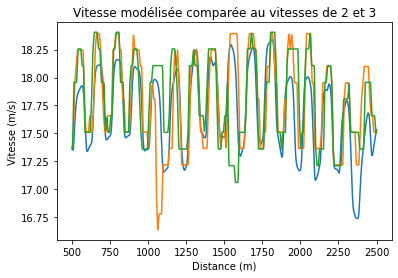

In [184]:
V_2_model = Vitesse(V_2(S[0]), S, lambda x: P_2(x), lambda x : drag_red_2(x))

plt.figure()
plt.plot(S, V_2_model, label = "modèle")
plt.plot(S, V_2(S), label = "2")
plt.plot(S, V_3(S), label = "3")
plt.xlabel("Distance (m)")
plt.ylabel("Vitesse (m/s)")
plt.title("Vitesse modélisée comparée au vitesses de 2 et 3")
plt.show()

In [172]:
def V_head(s):
    return V_2_model[min(round(s/(S[1] - S[0])), len(S) - 1)]

def P_model(s, drag_red):
    #dEm = M * 0.5 * ((lam(s + h, V_head(s+h))*V_head(s+h))**2 - (lam(s, V_head(s))*V_head(s))**2)/h + M*g*LG*(np.cos(beta(s+h,V_head(s+h)))-np.cos(beta(s,V_head(s))))/h
    dEm = 0
    Paero = drag_red * 0.5 * rho * SCd * (lam(s,V_head(s)))**3 * (V_head(s) **2)
    Pfric = mu * M * g * np.cos(alpha(s) - beta(s,V_head(s)))/np.cos(beta(s,V_head(s)))
    return ((dEm + Paero + Pfric)*V_head(s) / eta)


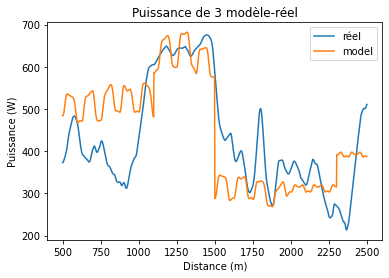

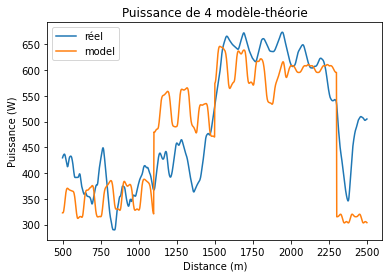

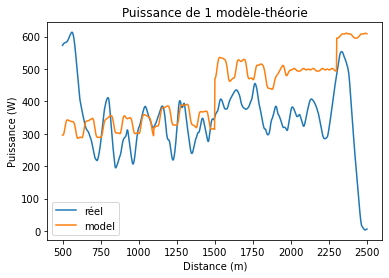

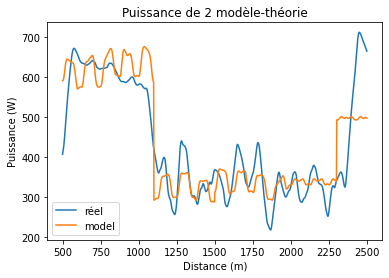

In [186]:
def P_model_3(s):
    return(P_model(s, drag_red_3(s)))

def P_model_4(s):
    return(P_model(s, drag_red_4(s)))

def P_model_1(s):
    return(P_model(s, drag_red_1(s)))

def P_model_2(s):
    return(P_model(s, drag_red_2(s)))


P_model_3 = np.vectorize(P_model_3)
P_model_4 = np.vectorize(P_model_4)
P_model_1 = np.vectorize(P_model_1)
P_model_2 = np.vectorize(P_model_2)

plt.figure()
plt.plot(S, P_3_conv(S), label = "réel")
plt.plot(S, P_model_3(S), label = "model")
plt.title("Puissance de 3 modèle-réel")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.legend()

plt.figure()
plt.plot(S, P_4_conv(S), label = "réel")
plt.plot(S, P_model_4(S), label = "model")
plt.title("Puissance de 4 modèle-théorie")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.legend()

plt.figure()
plt.plot(S, P_1_conv(S), label = "réel")
plt.plot(S, P_model_1(S), label = "model")
plt.title("Puissance de 1 modèle-théorie")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.legend()

plt.figure()
plt.plot(S, P_2_conv(S), label = "réel")
plt.plot(S, P_model_2(S), label = "model")
plt.title("Puissance de 2 modèle-théorie")
plt.xlabel("Distance (m)")
plt.ylabel("Puissance (W)")
plt.legend()

plt.show()